In [17]:


import math
import random
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import torch
import torch.nn as nn
import torch.optim as optim

from ortools.constraint_solver import pywrapcp, routing_enums_pb2


In [ ]:

# =========================
# Global knobs (easy tuning)
# =========================
SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# City / motion
R = 20.0                 # half "L1 radius" of diamond region; feasible points satisfy |x|+|y| <= R
V = 1.0                  # speed (distance units per minute)
DT = 0.5                 # minutes per step
HORIZON_MIN = 5760.0      # episode length in minutes (e.g., 4 hours)
STEPS_PER_EP = int(HORIZON_MIN / DT)
# terminal state: all packages delivered


# Demand & revenue
LAMBDA = 0.60            # ride arrival rate per minute (Poisson, spatially uniform over region)
R_PICK_ALPHA = 0.5      # pickup visibility radius parameter r = alpha * R / sqrt(2) (L1-constraint approx)
RT = 8.0                 # per-distance revenue for rides
RP = 1.0                 # revenue per delivered package
REWARD_SCALE = 1.0/8.0
INV_REWARD_SCALE = 1.0/REWARD_SCALE
REPORT_UNSCALED = True
GAMMA_PACK = 0.8        # package spatial intensity (packages per unit area); area = R^2 for diamond in L1 model
RIDE_TTL_MINUTES = 5    # ride request time to live in minutes

# DRL obs/action shaping
MAX_VISIBLE_RIDES = 5    # keep top-K closest pickups
K_NEAREST_PACK = 10      # encode nearest K packages
DISCOUNT = 0.99
PPO_STEPS = 4096
PPO_MINI_BATCH = 256
PPO_EPOCHS = 4
CLIP_EPS = 0.2
VF_COEF = 0.5
ENT_COEF = 0.02
LR = 3e-4
UPDATES = 200
GAE_LAMBDA = 0.95

# Heuristic
SWITCH_GRACE_STEPS = 6
HEUR_SOFT_PICK_CAP = None


EVAL_EPISODES = 5        # evaluation batch after each update

rng = np.random.default_rng(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# <<< MOD-SEED: per-combo deterministic seeds
def set_global_seeds(seed: int):
    """Reset all RNGs so each combo is reproducible & training path mimics main()."""
    global rng
    rng = np.random.default_rng(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)




In [19]:

# ==============
# Util functions
# ==============
def manhattan(a: np.ndarray, b: np.ndarray) -> float:
    return float(abs(a[0]-b[0]) + abs(a[1]-b[1]))

def l1_inside(x: float, y: float, r: float) -> bool:
    return abs(x) + abs(y) <= r

def sample_uniform_point_in_diamond(R: float) -> np.ndarray:
    # Rejection sampling in square [-R, R]^2 with L1 constraint
    while True:
        x = rng.uniform(-R, R)
        y = rng.uniform(-R, R)
        if abs(x) + abs(y) <= R:
            return np.array([x, y], dtype=np.float32)

# Normally, it won't go out of the diamond-shaped range. For robustness, 
# if it goes out due to numerical errors at the boundary, it needs to be projected back to the nearest boundary.
def project_to_diamond(p: np.ndarray, R: float) -> np.ndarray:
    # If |x|+|y|>R, project to boundary along direction to origin
    s = abs(p[0]) + abs(p[1])
    if s <= R:
        return p
    if s == 0:
        return np.array([0.0, 0.0], dtype=np.float32)
    return p * (R / s)

def step_towards(from_pt: np.ndarray, to_pt: np.ndarray, max_dist: float) -> Tuple[np.ndarray, float, bool]:
    """Move along Manhattan shortest path: first x, then y (or vice versa); return (new_pos, traveled, reached)"""
    x0, y0 = from_pt
    x1, y1 = to_pt
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    d = dx + dy
    if d <= max_dist:
        return to_pt.copy(), d, True
    # Move along x first
    move_x = min(dx, max_dist)
    sign_x = np.sign(x1 - x0)
    x_new = x0 + sign_x * move_x
    remaining = max_dist - move_x
    if remaining > 1e-8:
        move_y = min(dy, remaining)
        sign_y = np.sign(y1 - y0)
        y_new = y0 + sign_y * move_y
    else:
        y_new = y0
    p = np.array([x_new, y_new], dtype=np.float32)
    return p, max_dist, False



In [20]:

# ========================
# Environment (no zoning)
# ========================
@dataclass
class RideReq:
    pickup: np.ndarray
    dropoff: np.ndarray
    trip_len: float

class CoModalEnv:
    """
    - Region: diamond |x|+|y| <= R (L1 metric)
    - Packages: spatial Poisson with intensity gamma; N ~ Poisson(gamma * R^2), positions IID uniform in diamond
    - Ride arrivals: Poisson(LAMBDA * DT) per step, each with (origin, destination) uniform in diamond
    - Vehicle:
        * cannot deliver packages while carrying passenger (pickup->dropoff)
        * revenue: RP per delivered package; RT * (distance with passenger)
    - Action (discrete): 0 = continue delivering package; i=1..MAX_VISIBLE_RIDES = accept ith visible ride (if available)
      When busy enroute to pickup/dropoff, action is ignored (auto-continue).
    - Observation: vector with normalized features:
        * pos (x/R, y/R), time_frac, flags (to_pickup, with_pass)
        * K nearest packages: for each, (dx/R, dy/R, l1/R)
        * up to K rides visible: for each, (dx_pick/R, dy_pick/R, l1_pick/R, dx_drop/R, dy_drop/R, l1_trip/R)
        * counts: remaining_pkg / (1 + E[N]), current_visible / MAX_VISIBLE_RIDES
      Invalid slots are zero-padded. We also return an action mask for invalid ride indices.
    """
    def __init__(self,
                 R: float = R,
                 v: float = V,
                 dt: float = DT,
                 lam: float = LAMBDA,
                 gamma_pack: float = GAMMA_PACK,
                 rp: float = RP,
                 rt: float = RT,
                 r_pick_alpha: float = R_PICK_ALPHA,
                 ride_ttl_minutes: float=RIDE_TTL_MINUTES, #ride request time to live in minutes
                 max_visible: int = MAX_VISIBLE_RIDES): 
                 
        self.R = R
        self.v = v
        self.dt = dt
        self.lam = lam
        self.gamma = gamma_pack
        self.rp = rp * REWARD_SCALE
        self.rt = rt * REWARD_SCALE
        # max pickup radius (L1) following r = alpha * R / sqrt(2); we keep L1 constraint
        self.r_pick = r_pick_alpha * R / math.sqrt(2.0)

        self.max_visible = int(max_visible)
        self.k_pack = K_NEAREST_PACK
        self.ride_ttl_steps = max(1, int(round(ride_ttl_minutes / self.dt)))
        self._ended_reason: Optional[str] = None
        
        self.reset()

    def reset(self, seed: Optional[int] = None):
        if seed is not None:
            np.random.seed(seed)
        # sample packages (these are Voronoi seeds and also delivery points)
        area = self.R ** 2
        n_pkg = rng.poisson(self.gamma * area)
        n_pkg = max(1, int(n_pkg))
        pkg_list = [sample_uniform_point_in_diamond(self.R) for _ in range(n_pkg)]
        self.pkg_pos_all = np.asarray(pkg_list, dtype=np.float32)   # [N,2] fixed seeds for this episode
        self.pkg_delivered = np.zeros(n_pkg, dtype=bool)            # delivered flag for each seed
        self.pkg_remaining_idx = list(range(n_pkg))                 # indices of remaining seeds

        # a view for convenience in obs/_nearest_package:
        self.packages = self.pkg_pos_all[self.pkg_remaining_idx]

        # vehicle state
        self.pos = np.array([0.0, 0.0], dtype=np.float32)
        self.t = 0.0
        self.ride_buffer: List[Tuple[RideReq, int]] = []
        self.to_pickup: Optional[np.ndarray] = None
        self.with_passenger: bool = False
        self.drop_target: Optional[np.ndarray] = None

        self.revenue_cum = 0.0
        self._steps = 0
        self._ended_reason = None
        self.accepted_rides = 0
        
        self.time_rides_min = 0.0
        self.time_delivery_min = 0.0

        obs, mask = self._get_obs()
        return obs, mask

    def _append_new_ride(self, reqs: List[RideReq]):
        """Bring the new ride request to this buffer."""
        if not reqs:
            return
        ttl0 = self.ride_ttl_steps
        self.ride_buffer.extend([(r, ttl0) for r in reqs])

    def _sample_rides_this_step(self) -> List[RideReq]:
        k = rng.poisson(self.lam * self.dt)
        reqs = []
        for _ in range(int(k)):
            pk = sample_uniform_point_in_diamond(self.R)
            dp = sample_uniform_point_in_diamond(self.R)
            reqs.append(RideReq(pk, dp, manhattan(pk, dp)))
        return reqs

    def _visible_rides(self) -> List[RideReq]:
        # only show rides with pickup within r_pick (L1) AND we can reach pickup before TTL expires
        visible = []
        for (r, ttl) in self.ride_buffer:
            if ttl <= 0:
                continue
            # 1) Distance filtering: pickup must be within the visible radius
            if manhattan(self.pos, r.pickup) > self.r_pick:
                continue
            # 2) TTL + ETA filtering: must be able to reach pickup within the remaining TTL
            eta_min = manhattan(self.pos, r.pickup) / self.v
            if eta_min <= ttl * self.dt: 
                visible.append(r)
        # Sort by pickup distance and truncate
        visible.sort(key=lambda rr: manhattan(self.pos, rr.pickup))
        return visible[:self.max_visible]


    def _nearest_package(self) -> Optional[np.ndarray]:
        if len(self.packages) == 0:
            return None
        dists = np.abs(self.packages - self.pos).sum(axis=1)
        idx = int(np.argmin(dists))
        return self.packages[idx].copy()


    def _deliver_if_arrived(self):
        """Deliver any packages exactly at current location; update delivered flags & remaining set."""
        if len(self.pkg_remaining_idx) == 0:
            return 0
        # distances to remaining only
        rem_pos = self.pkg_pos_all[self.pkg_remaining_idx]  # [M,2]
        dists = np.abs(rem_pos - self.pos).sum(axis=1)
        hit_local = np.where(dists < 1e-6)[0]               # local indices in 'remaining view'
        delivered = int(len(hit_local))
        if delivered > 0:
            # map local -> global seed idx, mark delivered, and remove from remaining
            for k in sorted(hit_local, reverse=True):
                gidx = self.pkg_remaining_idx[k]
                self.pkg_delivered[gidx] = True
                self.pkg_remaining_idx.pop(k)
            # refresh convenience view
            self.packages = self.pkg_pos_all[self.pkg_remaining_idx]
            # reward
            self.revenue_cum += self.rp * delivered
        return delivered

    # ---- L1-Voronoi helpers ----
    def voronoi_owner_idx(self, pt: np.ndarray) -> int:
        """Return argmin_j L1(pt, pkg_pos_all[j]) (global seed index)."""
        dif = np.abs(self.pkg_pos_all - pt[None, :]).sum(axis=1)   # [N]
        return int(np.argmin(dif))

    def dropoff_allowed(self, drop: np.ndarray) -> bool:
        """Disallow if drop falls into Voronoi cell of an already delivered package."""
        owner = self.voronoi_owner_idx(drop)
        return not bool(self.pkg_delivered[owner])

    def _get_obs(self) -> Tuple[np.ndarray, np.ndarray]:
        # Visible rides & nearest packages
        visible = self._visible_rides()
        # Packages features
        pack_feats = []
        if len(self.packages) > 0:
            d = np.abs(self.packages - self.pos).sum(axis=1)
            order = np.argsort(d)[:self.k_pack]
            for j in order:
                rel = (self.packages[j] - self.pos) / self.R
                pack_feats.extend([rel[0], rel[1], d[j] / self.R])
        # pad
        while len(pack_feats) < 3 * self.k_pack:
            pack_feats.append(0.0)

        ride_feats = []
        for r in visible:
            relp = (r.pickup - self.pos) / self.R
            reld = (r.dropoff - self.pos) / self.R
            ride_feats.extend([relp[0], relp[1], manhattan(self.pos, r.pickup) / self.R,
                               reld[0], reld[1], r.trip_len / self.R])
        while len(ride_feats) < 6 * self.max_visible:
            ride_feats.append(0.0)

        time_frac = self.t / HORIZON_MIN
        flags = [1.0 if self.to_pickup is not None else 0.0,
                 1.0 if self.with_passenger else 0.0]

        counts = [len(self.packages) / (1.0 + self.gamma * (self.R ** 2)),
                  len(visible) / float(self.max_visible)]

        core = [self.pos[0] / self.R, self.pos[1] / self.R, time_frac] + flags + counts
        obs = np.array(core + pack_feats + ride_feats, dtype=np.float32)

        # Action mask: 0 always valid; i>0 valid if i<=len(visible)
        mask = np.zeros(1 + self.max_visible, dtype=np.float32)
        mask[0] = 1.0
        for i in range(len(visible)):
            mask[1 + i] = 1.0
        return obs, mask

    def step(self, action: int):
        reward = 0.0
        done = False
        delivered_step = 0 # track how many packages delivered in this step

        # --- At the beginning of CoModalEnv.step(self, action), determine the attribution of this step ---
        # Use the state at the beginning of the step to determine its attribution
        is_ride_phase = (self.to_pickup is not None) or self.with_passenger

        
        # add fresh arrivals
        self._append_new_ride(self._sample_rides_this_step())

        # If busy towards pickup or with passenger, ignore action (auto-continue)
        if self.to_pickup is not None:
            # move towards pickup
            new_pos, d, reached = step_towards(self.pos, self.to_pickup, self.v * self.dt)
            self.pos = project_to_diamond(new_pos, self.R)
            if reached:
                self.to_pickup = None
                self.with_passenger = True
            # cannot deliver while enroute to pickup
        elif self.with_passenger:
            # move towards dropoff; accrue ride revenue per distance traveled
            new_pos, d, reached = step_towards(self.pos, self.drop_target, self.v * self.dt)
            self.pos = project_to_diamond(new_pos, self.R)
            reward += self.rt * d    # ride distance revenue in this step
            self.revenue_cum += self.rt * d
            if reached:
                self.with_passenger = False
                self.drop_target = None
        else:
            # free: can choose to deliver or accept a visible ride
            visible = self._visible_rides()
            if action > 0 and action <= len(visible):
                chosen = visible[action - 1]
                # remove chosen from buffer
                # (remove by identity)
                for i, (r, ttl) in enumerate(self.ride_buffer):
                    if r is chosen:
                        self.ride_buffer.pop(i)
                        break
                # set pickup/drop targets
                self.to_pickup = chosen.pickup.copy()
                self.drop_target = chosen.dropoff.copy()
                self.accepted_rides += 1
                # move towards pickup immediately this step
                new_pos, d, reached = step_towards(self.pos, self.to_pickup, self.v * self.dt)
                self.pos = project_to_diamond(new_pos, self.R)
                if reached:
                    self.to_pickup = None
                    self.with_passenger = True
            else:
                # deliver: go to nearest package (if any)
                target = self._nearest_package()
                if target is not None:
                    new_pos, d, reached = step_towards(self.pos, target, self.v * self.dt)
                    self.pos = project_to_diamond(new_pos, self.R)
                    if reached:
                        delivered = self._deliver_if_arrived()
                        delivered_step += delivered
                        reward += self.rp * delivered
                # else idle at current location

        # small clean-up: remove stale rides outside pickup radius (we keep buffer but they vanish after 1 step) and TTL Decay
        # simple model: unaccepted rides expire by end of step
        if self.ride_buffer:
            new_buf = []
            for (r, ttl) in self.ride_buffer:
                ttl -= 1
                if ttl > 0:
                    new_buf.append((r, ttl))
            self.ride_buffer = new_buf

        self.t += self.dt
        self._steps += 1

        # Deliver any packages exactly at position (numerical safety)
        if self.to_pickup is None and not self.with_passenger:
            delivered = self._deliver_if_arrived()
            if delivered > 0:
                delivered_step += delivered
                reward += self.rp * delivered
        
        if is_ride_phase:
            self.time_rides_min += self.dt
        else:
            self.time_delivery_min += self.dt
        
        # ---------- termination checks & terminal info ----------
        done_horizon = (self.t >= HORIZON_MIN)
        done_packages = (len(self.packages) == 0) and (not self.with_passenger) and (self.to_pickup is None)
        
        if done_packages or done_horizon:
            done = True
            self._ended_reason = "packages_done" if done_packages else "horizon_reached"
        
        info: Dict[str, object] = {}
        if done:
            info["terminal_time_min"] = float(self.t)
            info["ended_reason"] = self._ended_reason
            info["accepted_rides"] = int(self.accepted_rides)
            info["time_rides_min"] = float(self.time_rides_min)
            info["time_delivery_min"] = float(self.time_delivery_min)

        info["delivered_step"] = int(delivered_step)
        
        obs, mask = self._get_obs()
        return obs, reward, done, info, mask

    @property
    def obs_dim(self):
        # core (3 + 2 flags + 2 counts) + 3*K + 6*MAX_VISIBLE
        return (3 + 2 + 2) + 3 * self.k_pack + 6 * self.max_visible

    @property
    def act_dim(self):
        return 1 + self.max_visible



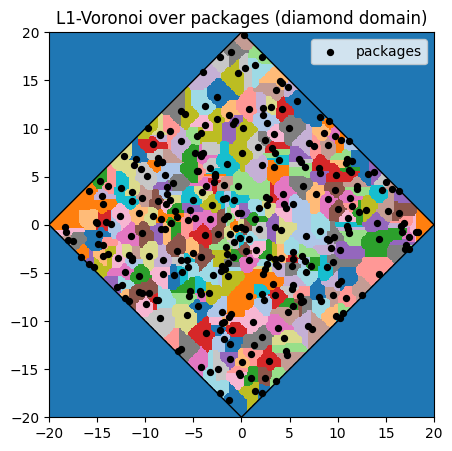

In [21]:
def plot_l1_voronoi_for_env(env: CoModalEnv, res: int = 200, show_delivered: bool = True):
    """
    Approximates and plots the L1-Voronoi diagram for the given seeds (env.pkg_pos_all),
    clipped to a diamond-shaped region defined by |x|+|y|<=R.
    - res: The resolution of the grid (number of pixels per side).
    """
    R = env.R
    # Generate grid
    xs = np.linspace(-R, R, res)
    ys = np.linspace(-R, R, res)
    XX, YY = np.meshgrid(xs, ys)
    mask = (np.abs(XX) + np.abs(YY) <= R)           # Points within the diamond
    Xflat = XX[mask]; Yflat = YY[mask]
    P = np.stack([Xflat, Yflat], axis=1)            # [M,2]

    # For each grid point, find the nearest seed (L1 distance)
    seeds = env.pkg_pos_all                         # [N,2]
    # A direct O(MN) approach is sufficient; for large N, consider KDTree(metric='manhattan')
    owner = np.argmin(np.abs(P[:,None,:] - seeds[None,:,:]).sum(axis=2), axis=1)  # [M]

    # Fill the owner indices back into the image
    img = -np.ones_like(XX, dtype=int)
    img[mask] = owner

    # Plotting
    plt.figure(figsize=(5,5))
    plt.imshow(img, origin="lower",
               extent=[-R, R, -R, R], interpolation="nearest", cmap="tab20")
    # Draw the diamond boundary
    bx = np.array([-R, 0, R, 0, -R]); by = np.array([0, R, 0, -R, 0])
    plt.plot(bx, by, "k-", lw=1.0)
    # Draw the seed points
    plt.scatter(seeds[:,0], seeds[:,1], s=18, c="k", marker="o", label="packages")
    if show_delivered and hasattr(env, "pkg_delivered"):
        dmask = env.pkg_delivered
        if dmask.any():
            plt.scatter(seeds[dmask,0], seeds[dmask,1], s=30, facecolors="none", edgecolors="w", linewidths=1.5, label="delivered")
    plt.title("L1-Voronoi over packages (diamond domain)")
    plt.xlim([-R, R]); plt.ylim([-R, R]); plt.gca().set_aspect("equal", adjustable="box")
    plt.legend(loc="upper right")
    plt.show()


tmp = CoModalEnv()       # Generate an episode with current global parameters
plot_l1_voronoi_for_env(tmp, res=300)


In [22]:

# =================
# Baseline policies
# =================
def run_episode(env: CoModalEnv, policy=None, greedy=False) -> Tuple[float, float, float, str, int, float, float]:
    obs, mask = env.reset()
    total = 0.0
    terminal_time = None
    ended_reason = "unknown"
    acc = 0
    t_rides = 0.0
    t_delivery = 0.0
    for _ in range(STEPS_PER_EP):
        if policy is None:
            # default: deliver-only baseline
            action = 0
        else:
            with torch.no_grad():
                o = torch.tensor(obs, dtype=torch.float32, device=DEVICE).unsqueeze(0)
                m = torch.tensor(mask, dtype=torch.float32, device=DEVICE).unsqueeze(0)
                logits, _ = policy(o)
                # mask invalid
                invalid = (m < 0.5)
                logits = logits.masked_fill(invalid, -1e9)
                if greedy:
                    action = int(torch.argmax(logits, dim=-1).item())
                else:
                    probs = torch.softmax(logits, dim=-1)
                    action = int(torch.multinomial(probs, 1).item())
        obs, r, done, info, mask = env.step(action)
        total += r
        if done:
            terminal_time = float(info.get("terminal_time_min", env.t))
            ended_reason = str(info.get("ended_reason", env._ended_reason or "unknown"))
            acc = int(info.get("accepted_rides", getattr(env, "accepted_rides", 0)))
            t_rides = float(info.get("time_rides_min", 0.0))
            t_delivery = float(info.get("time_delivery_min", 0.0))
            break
    if terminal_time is None:
        terminal_time = float(env.t)
        t_rides = float(getattr(env, "time_rides_min", 0.0))
        t_delivery = float(getattr(env, "time_delivery_min", 0.0))
        
    revenue_rate = total / terminal_time if terminal_time > 0 else 0.0
    
    return total, terminal_time, revenue_rate, ended_reason, acc, t_rides, t_delivery


def baseline_nearby_rule(env: CoModalEnv,
                         pickup_alpha=R_PICK_ALPHA,
                         drop_bias=0.5,
                         switch_grace_steps: Optional[int] = None
                         ) -> Tuple[float, float, float, str, int, float, float]:
   
    obs, mask = env.reset()
    total = 0.0
    terminal_time = None
    ended_reason = "unknown"
    acc = 0
    t_rides = 0.0
    t_delivery = 0.0

    grace_left = 0

    for _ in range(STEPS_PER_EP):
        visible = env._visible_rides()
        action = 0  # Default: go to the nearest package
        
        gs = SWITCH_GRACE_STEPS if switch_grace_steps is None else int(switch_grace_steps)
        
        #Pre-grace
        # If the nearest package can be delivered in the next step, open the window in advance
        nn = env._nearest_package()
        if nn is not None:
            dist_to_nn = manhattan(env.pos, nn)
            if grace_left == 0 and dist_to_nn <= (env.v * env.dt):
                grace_left = max(1, gs)
                

        if grace_left > 0:
            # Inside the window: as long as there is a qualified order, accept the one with the nearest pickup
            if len(visible) > 0:
                # Accept the one with the nearest pickup
                pk_d_list = [manhattan(env.pos, r.pickup) for r in visible]
                if HEUR_SOFT_PICK_CAP and min(pk_d_list) <= HEUR_SOFT_PICK_CAP:
                    action = 1 + int(np.argmin(pk_d_list))
                    grace_left = 0
                    
                else:
                    action = 1 + int(np.argmin(pk_d_list))
                    grace_left = 0
            else:
                # If there are no qualified orders in the window, decrement the window counter
                grace_left -= 1

        # Execute action
        obs, r, done, info, mask = env.step(action)
        total += r

        delivered_cnt = int(info.get("delivered_step", 0))
        if delivered_cnt > 0:
            # After delivering the package: open a new window (including the current and subsequent SWITCH_GRACE_STEPS steps)
            grace_left = max(1, gs)


        if done:
            terminal_time = float(info.get("terminal_time_min", env.t))
            ended_reason  = str(info.get("ended_reason", env._ended_reason or "unknown"))
            acc = int(info.get("accepted_rides", getattr(env, "accepted_rides", 0)))
            t_rides = float(info.get("time_rides_min", 0.0))
            t_delivery = float(info.get("time_delivery_min", 0.0))
            break

    if terminal_time is None:
        terminal_time = float(env.t)
    revenue_rate = (total / terminal_time) if terminal_time > 0 else 0.0
    return total, terminal_time, revenue_rate, ended_reason, acc, t_rides, t_delivery


def baseline_nearby_rule_voronoi(env: CoModalEnv,
                                 pickup_alpha=R_PICK_ALPHA,
                                 drop_bias=0.5,
                                 switch_grace_steps: Optional[int] = None
                                 ) -> Tuple[float, float, float, str, int, float, float]:
    """
    Switching policy (N=n) + L1-Voronoi dropoff filter:
      - Only consider accepting rides within a window of a few steps after delivering a package.
      - Filter candidate passengers first: the dropoff must not fall into the L1-Voronoi cell of a delivered package.
      - If there are still candidates after filtering, accept the one with the nearest pickup; otherwise, continue delivering the nearest package.
    Returns: (total_reward, terminal_time_min, revenue_rate, ended_reason, accepted_rides)
    """
    obs, mask = env.reset()
    total = 0.0
    terminal_time = None
    ended_reason = "unknown"
    acc = 0
    grace_left = 0
    t_rides = 0.0
    t_delivery = 0.0

    gs = SWITCH_GRACE_STEPS if switch_grace_steps is None else int(switch_grace_steps)

    for _ in range(STEPS_PER_EP):
        visible = env._visible_rides()
        action = 0

        # If the nearest package can be delivered in the next step, open the window in advance
        nn = env._nearest_package()
        if nn is not None:
            dist_to_nn = manhattan(env.pos, nn)
            if grace_left == 0 and dist_to_nn <= (env.v * env.dt):
                grace_left = max(1, gs)

        if grace_left > 0:
            # First, use the Voronoi rule to filter out rides whose dropoff falls into a delivered package's cell
            cand = [r for r in visible if env.dropoff_allowed(r.dropoff)]
            if len(cand) > 0:
                # Accept the ride with the nearest pickup
                pk_d_list = [manhattan(env.pos, r.pickup) for r in cand]
                action = 1 + int(np.argmin(pk_d_list))
                grace_left = 0
            else:
                grace_left -= 1

        obs, r, done, info, mask = env.step(action)
        total += r

        delivered_cnt = int(info.get("delivered_step", 0))   # Note: your env uses "delivered_step"
        if delivered_cnt > 0:
            grace_left = max(1, gs)

        if done:
            terminal_time = float(info.get("terminal_time_min", env.t))
            ended_reason  = str(info.get("ended_reason", env._ended_reason or "unknown"))
            acc = int(info.get("accepted_rides", getattr(env, "accepted_rides", 0)))
            t_rides = float(info.get("time_rides_min", 0.0))
            t_delivery = float(info.get("time_delivery_min", 0.0))
            break

    if terminal_time is None:
        terminal_time = float(env.t)
        t_rides = float(getattr(env, "time_rides_min", 0.0))
        t_delivery = float(getattr(env, "time_delivery_min", 0.0))
        
    revenue_rate = (total / terminal_time) if terminal_time > 0 else 0.0
    return total, terminal_time, revenue_rate, ended_reason, acc, t_rides, t_delivery



In [23]:
# =================
# Four zone baseline policies relevant
# =================

# =========================
# Four-zone helpers (L1)
# =========================

def l1_zone_id(p: np.ndarray) -> int:
    """
    Divides the diamond-shaped region into four zones based on L1 criteria:
      zone 0: |x|>=|y| and x>=0  -> Right
      zone 1: |x|>=|y| and x<0   -> Left
      zone 2: |y|>|x| and y>=0   -> Top
      zone 3: |y|>|x| and y<0    -> Bottom
    """
    x, y = float(p[0]), float(p[1])
    if abs(x) >= abs(y):
        return 0 if x >= 0 else 1
    else:
        return 2 if y >= 0 else 3


def _l1_distance(a: Tuple[float,float], b: Tuple[float,float]) -> int:
    # OR-Tools requires an integer matrix; here we use an integer approximation by scaling by 1000, or simply rounding.
    return int(round(abs(a[0]-b[0]) + abs(a[1]-b[1])))


def _build_distance_matrix_L1(pts: List[Tuple[float,float]]) -> List[List[int]]:
    n = len(pts)
    mat = [[0]*n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if i != j:
                mat[i][j] = _l1_distance(pts[i], pts[j])
    return mat


def solve_zone_tsp_L1(points_xy: List[Tuple[float,float]],
                      start_xy: Tuple[float,float]) -> List[int]:
    """
    Given package points within a zone (points_xy) and a starting point (start_xy),
    use OR-Tools to solve an approximate TSP visiting order and return the index sequence for visiting points_xy.
    - We construct a virtual depot = start_xy, connected to all points;
    - The goal is to visit all points starting from the depot (end point is arbitrary).
    """
    if not points_xy:
        return []

    # Construct node list: node 0 = depot (start), 1..n = package points
    all_points = [start_xy] + list(points_xy)
    dist = _build_distance_matrix_L1(all_points)

    n_nodes = len(all_points)
    manager = pywrapcp.RoutingIndexManager(n_nodes, 1, 0)   # Single vehicle, depot=0
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        i = manager.IndexToNode(from_index)
        j = manager.IndexToNode(to_index)
        return dist[i][j]

    transit_cb_idx = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_cb_idx)

    # Allow not returning to the depot; by default, it will find a path starting from the depot
    search_params = pywrapcp.DefaultRoutingSearchParameters()
    search_params.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )
    search_params.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    )
    search_params.time_limit.FromSeconds(2)  # Sufficient for small scale

    solution = routing.SolveWithParameters(search_params)
    if solution is None:
        # Fallback: If OR-Tools provides no solution, sort by nearest neighbor from the start
        order = sorted(range(len(points_xy)),
                       key=lambda k: abs(points_xy[k][0]-start_xy[0]) + abs(points_xy[k][1]-start_xy[1]))
        return order

    # Parse path: node number -> points index (subtract 1)
    idx = routing.Start(0)
    visit_order = []
    while not routing.IsEnd(idx):
        node = manager.IndexToNode(idx)
        if node != 0:  # Skip depot
            visit_order.append(node - 1)
        idx = solution.Value(routing.NextVar(idx))
    return visit_order

# =================
# Four zone baseline algorithm
# =================


def baseline_four_zone(env: CoModalEnv,
                       r_pick_alpha: float = R_PICK_ALPHA,
                       screen_window_min: float = 10.0
                       ) -> Tuple[float, float, float, str, int, float, float]:
    """
    Four-Zone Policy (FZ):
      1) Divide all packages into 4 zones by l1_zone_id and clear them one by one;
      2) Within a zone, use OR-Tools to find an approximate TSP visiting order and follow it strictly;
      3) In the "final leg" within a zone, open a passenger screening window (lasting screen_window_min minutes):
           Only consider visible rides where pickup is within r_pick, TTL is valid, and dropoff is in an "unserved" zone;
         but **only accept a ride after clearing the current zone** (if it's still visible); if no rides, proceed to the next unserved zone;
      4) After completing a ride, if it lands in an unserved zone, that zone becomes the next one to service.
    Output is consistent with other baselines: (reward, terminal_time, rate, ended_reason, accepted)
    """
    obs, mask = env.reset()
    total, terminal_time = 0.0, None
    ended_reason = "unknown"
    acc = 0
    t_rides = 0.0
    t_delivery = 0.0

    # Pre-fetch constants
    r_pick = r_pick_alpha * env.R / math.sqrt(2.0)
    screen_steps = max(1, int(round(screen_window_min / env.dt)))

    # Initial partitioning based on packages at reset
    def packages_by_zone():
        zones = {0: [], 1: [], 2: [], 3: []}
        for p in env.packages:
            zones[l1_zone_id(p)].append((float(p[0]), float(p[1])))
        return zones

    zones = packages_by_zone()

    def zone_has_pkg(zid: int) -> bool:
        return len(zones[zid]) > 0

    def pick_next_zone(cur_pos: np.ndarray) -> Optional[int]:
        # Select the "nearest un-cleared zone" (measured by L1 distance to the nearest package in that zone)
        best, best_d = None, 1e18
        for zid in range(4):
            if not zone_has_pkg(zid):
                continue
            d_min = min(abs(px-cur_pos[0]) + abs(py-cur_pos[1]) for (px,py) in zones[zid])
            if d_min < best_d:
                best, best_d = zid, d_min
        return best

    # Plan TSP order for a zone (based on current env.pos)
    def plan_zone_route(zid: int) -> List[Tuple[float,float]]:
        pts = zones[zid]
        order = solve_zone_tsp_L1(pts, (float(env.pos[0]), float(env.pos[1])))
        return [pts[k] for k in order]

    # Filter acceptable passengers (meeting r_pick/TTL and dropoff in an unserved zone)
    def screened_visible_in_unserved():
        cand = []
        visible = env._visible_rides()
        unserved_zids = {z for z in range(4) if zone_has_pkg(z)}
        for r in visible:
            zid = l1_zone_id(r.dropoff)
            if zid in unserved_zids:
                # Re-verify pickup distance (env._visible_rides already filters by TTL+radius)
                if manhattan(env.pos, r.pickup) <= r_pick:
                    cand.append(r)
        # Select the one with the nearest pickup
        cand.sort(key=lambda rr: manhattan(env.pos, rr.pickup))
        return cand

    current_zone = pick_next_zone(env.pos)
    route = plan_zone_route(current_zone) if current_zone is not None else []

    # Route pointer & screening window counter
    idx_in_route = 0
    screen_left = 0
    have_candidate = False   # Flag that a qualified ride is available, but wait until the zone is clear to accept

    for _ in range(STEPS_PER_EP):
        action = 0  # Default to delivering packages
        # If no current zone, try to pick one
        if current_zone is None:
            current_zone = pick_next_zone(env.pos)
            if current_zone is not None:
                route = plan_zone_route(current_zone)
                idx_in_route = 0

        # If there are still target points in the zone, move towards the next one
        if current_zone is not None and idx_in_route < len(route):
            target = np.array(route[idx_in_route], dtype=np.float32)
            # If the next step is reachable (will arrive at the point), open the screening window in the "final leg"
            dist_to_target = manhattan(env.pos, target)
            if screen_left == 0 and dist_to_target <= (env.v * env.dt):
                screen_left = screen_steps

        # Within the screening window: only screen, do not accept (until the zone is cleared)
        if screen_left > 0:
            screen_left -= 1
            cand = screened_visible_in_unserved()
            have_candidate = have_candidate or (len(cand) > 0)

        # Select action
        if env.to_pickup is not None or env.with_passenger:
            # Currently picking up/transporting a passenger, action is ignored
            pass
        else:
            # If the current zone is cleared (determined at runtime based on env.packages), allow trying to accept a ride
            # We consider the zone cleared if: zones[current_zone] ∩ env.packages == ∅
            if current_zone is not None:
                # Synchronize zones: remove delivered packages from zones (by coordinate matching)
                # Note: env._deliver_if_arrived() is only triggered upon arrival at a point, here we use approximate matching
                alive = set((float(p[0]), float(p[1])) for p in env.packages)
                zones[current_zone] = [pt for pt in zones[current_zone] if pt in alive]

                if len(zones[current_zone]) == 0:
                    # Current zone cleared: if there's a qualified candidate and it's still visible, accept it now (otherwise, move to the next un-cleared zone)
                    if have_candidate:
                        visible = env._visible_rides()
                        # Pick one based on nearest pickup and dropoff in an unserved zone
                        best_idx, best_d = -1, 1e18
                        for i, r in enumerate(visible):
                            if l1_zone_id(r.dropoff) in {z for z in range(4) if zone_has_pkg(z)}:
                                d = manhattan(env.pos, r.pickup)
                                if d < best_d:
                                    best_d, best_idx = d, i
                        if best_idx >= 0:
                            action = 1 + best_idx
                            have_candidate = False
                    # If no qualified ride was accepted, move to the next un-cleared zone and replan
                    if action == 0:
                        current_zone = pick_next_zone(env.pos)
                        if current_zone is not None:
                            route = plan_zone_route(current_zone)
                            idx_in_route = 0

            # Not transporting a passenger and no ride acceptance triggered, so continue delivering packages along the route
            # (Based on the "deliver only upon arrival" mechanism in env.step, action=0 is sufficient)
            pass

        # Execute action
        obs, r, done, info, mask = env.step(action)
        total += r
        if done:
            terminal_time = float(info.get("terminal_time_min", env.t))
            ended_reason  = str(info.get("ended_reason", env._ended_reason or "unknown"))
            acc = int(info.get("accepted_rides", getattr(env, "accepted_rides", 0)))
            t_rides = float(info.get("time_rides_min", 0.0))
            t_delivery = float(info.get("time_delivery_min", 0.0))
            break

        # If a delivery was just successful, advance the route pointer (using the delivered_step flag)
        delivered_cnt = int(info.get("delivered_step", 0))
        if delivered_cnt > 0 and current_zone is not None and idx_in_route < len(route):
            # If current position equals route[idx], move forward
            cur = (float(env.pos[0]), float(env.pos[1]))
            if idx_in_route < len(route) and cur == route[idx_in_route]:
                idx_in_route += 1

    if terminal_time is None:
        terminal_time = float(env.t)
    revenue_rate = total / terminal_time if terminal_time > 0 else 0.0
    return total, terminal_time, revenue_rate, ended_reason, acc, t_rides, t_delivery



In [24]:

# ==============
# PPO Components
# ==============
class ActorCritic(nn.Module):
    def __init__(self, obs_dim: int, act_dim: int):
        super().__init__()
        hid = 256
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hid), 
            nn.LayerNorm(hid),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hid, hid), 
            nn.LayerNorm(hid),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
        self.pi = nn.Linear(hid, act_dim)
        self.v  = nn.Linear(hid, 1)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        h = self.net(x)
        return self.pi(h), self.v(h)


def ppo_update(policy: ActorCritic, optimizer, batch, clip_eps=CLIP_EPS):
    obs, act, old_logp, ret, adv, mask = batch
    logits, v = policy(obs)
    # mask invalid actions
    invalid = (mask < 0.5)
    logits = logits.masked_fill(invalid, -1e9)
    dist = torch.distributions.Categorical(logits=logits)
    logp = dist.log_prob(act)
    ratio = torch.exp(logp - old_logp)

    clip_adv = torch.clamp(ratio, 1.0 - clip_eps, 1.0 + clip_eps) * adv
    pi_loss = -(torch.min(ratio * adv, clip_adv)).mean()
    v_loss = ((ret - v.squeeze(-1)) ** 2).mean()

    ent = dist.entropy().mean()
    loss = pi_loss + VF_COEF * v_loss - ENT_COEF * ent

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(policy.parameters(), 1.0)
    optimizer.step()

    return pi_loss.item(), v_loss.item(), ent.item(), loss.item()


def collect_rollout(env: CoModalEnv, policy: ActorCritic, steps: int):
    # buffers
    obs_buf, act_buf, rew_buf, val_buf, next_val_buf, logp_buf, mask_buf, done_buf = [], [], [], [], [], [], [], []

    obs, mask = env.reset()
    for _ in range(steps):
        o = torch.tensor(obs, dtype=torch.float32, device=DEVICE).unsqueeze(0)
        m = torch.tensor(mask, dtype=torch.float32, device=DEVICE).unsqueeze(0)
        with torch.no_grad():
            logits, v = policy(o)
            invalid = (m < 0.5)
            logits = logits.masked_fill(invalid, -1e9)
            dist = torch.distributions.Categorical(logits=logits)
            a = dist.sample()
            logp = dist.log_prob(a).squeeze(0)
            v_cur = v.squeeze(0).squeeze(-1)             # V(s_t)

        # step env
        obs2, r, done, _, mask2 = env.step(int(a.item()))

        # compute V(s_{t+1}) for GAE bootstrap
        with torch.no_grad():
            o2 = torch.tensor(obs2, dtype=torch.float32, device=DEVICE).unsqueeze(0)
            _, v_next = policy(o2)
            v_next = v_next.squeeze(0).squeeze(-1)       # V(s_{t+1})

        # store
        obs_buf.append(o.squeeze(0).cpu().numpy())
        mask_buf.append(m.squeeze(0).cpu().numpy())
        act_buf.append(a.cpu().numpy())
        rew_buf.append(r)
        val_buf.append(v_cur.cpu().numpy())
        next_val_buf.append(v_next.cpu().numpy())
        logp_buf.append(logp.cpu().numpy())
        done_buf.append(done)

        obs, mask = obs2, mask2
        if done:
            obs, mask = env.reset()

    # ---------- GAE(λ) advantages & returns ----------
    # arrays
    rewards = np.array(rew_buf, dtype=np.float32)
    values  = np.array(val_buf, dtype=np.float32)
    next_values = np.array(next_val_buf, dtype=np.float32)
    dones   = np.array(done_buf, dtype=np.float32)  # 1.0 if done else 0.0

    advantages = np.zeros_like(rewards, dtype=np.float32)
    gae = 0.0
    gamma = DISCOUNT
    lam = GAE_LAMBDA

    # backward recursion
    for t in reversed(range(len(rewards))):
        nonterminal = 1.0 - dones[t]
        delta = rewards[t] + gamma * next_values[t] * nonterminal - values[t]
        gae = delta + gamma * lam * nonterminal * gae
        advantages[t] = gae

    returns = advantages + values  # target for value head

    # tensors
    obs_t  = torch.tensor(np.array(obs_buf), dtype=torch.float32, device=DEVICE)
    act_t  = torch.tensor(np.array(act_buf).squeeze(-1), dtype=torch.long, device=DEVICE)
    ret_t  = torch.tensor(returns, dtype=torch.float32, device=DEVICE)
    adv_t  = torch.tensor(advantages, dtype=torch.float32, device=DEVICE)
    logp_t = torch.tensor(np.array(logp_buf), dtype=torch.float32, device=DEVICE)
    mask_t = torch.tensor(np.array(mask_buf), dtype=torch.float32, device=DEVICE)

    # normalize advantages (keep returns unnormalized)
    adv_t = (adv_t - adv_t.mean()) / (adv_t.std() + 1e-8)

    return obs_t, act_t, logp_t, ret_t, adv_t, mask_t



def make_minibatches(batch, batch_size):
    N = batch[0].shape[0]
    idx = np.arange(N)
    rng.shuffle(idx)
    for i in range(0, N, batch_size):
        j = idx[i:i+batch_size]
        yield tuple(x[j] for x in batch)


In [25]:
def evaluate_all(env: CoModalEnv, policy: ActorCritic, heur_grace_steps: Optional[int] = None):
    prev_mode = policy.training
    policy.eval()
    try:
        drl_eps   = [run_episode(env, policy, greedy=True)        for _ in range(EVAL_EPISODES)]
        pure_eps  = [run_episode(env, policy=None)                for _ in range(EVAL_EPISODES)]
        heur_eps  = [baseline_nearby_rule(env, heur_grace_steps)  for _ in range(EVAL_EPISODES)]
        hv_eps    = [baseline_nearby_rule_voronoi(env, heur_grace_steps) for _ in range(EVAL_EPISODES)]
        fz_eps    = [baseline_four_zone(env) for _ in range(EVAL_EPISODES)]

        def _descale_eps(eps):
            if not REPORT_UNSCALED:
                return eps
            fixed = []
            for e in eps:
                if len(e) == 7:
                    R, T, Rate, reason, acc, t_R, t_D = e
                    fixed.append((R * INV_REWARD_SCALE, T, Rate * INV_REWARD_SCALE, reason, acc, t_R, t_D))
                elif len(e) == 5:
                    R, T, Rate, reason, acc = e
                    fixed.append((R * INV_REWARD_SCALE, T, Rate * INV_REWARD_SCALE, reason, acc))
                else:
                    R, T, Rate, reason = e
                    fixed.append((R * INV_REWARD_SCALE, T, Rate * INV_REWARD_SCALE, reason))
            return fixed

        drl_out = _descale_eps(drl_eps)
        pure_out= _descale_eps(pure_eps)
        heur_out= _descale_eps(heur_eps)
        hv_out  = _descale_eps(hv_eps)
        fz_out  = _descale_eps(fz_eps)

        def agg(eps):
            R  = np.array([e[0] for e in eps], dtype=float)
            T  = np.array([e[1] for e in eps], dtype=float)
            Rt = np.array([e[2] for e in eps], dtype=float)
            reasons = [e[3] for e in eps]

            out = dict(
                avg_reward = float(R.mean()),
                avg_t      = float(T.mean()),  
                avg_rate   = float(Rt.mean())
            )

            # Add: finish_rate and avg_finish_time (conditional average for packages_done only)
            done_mask = np.array([1.0 if r == "packages_done" else 0.0 for r in reasons], dtype=float)
            finish_cnt = int(done_mask.sum())
            out["finish_rate"] = float(finish_cnt / len(eps))
            if finish_cnt > 0:
                out["avg_finish_time"] = float(T[done_mask == 1].mean())
            else:
                out["avg_finish_time"] = float("nan")

            if len(eps[0]) == 5:
                A  = np.array([e[4] for e in eps], dtype=float)
                out["avg_acc"] = float(A.mean())
            if len(eps[0]) == 7:
                A  = np.array([e[4] for e in eps], dtype=float)
                out["avg_acc"] = float(A.mean())
                tR = np.array([e[5] for e in eps], dtype=float)
                tD = np.array([e[6] for e in eps], dtype=float)
                out["avg_time_rides"] = float(tR.mean())
                out["avg_time_delivery"] = float(tD.mean())
            return out

        def pprint(name, eps):
            print(f"  {name} episodes:")
            if len(eps[0]) == 7:
                for i, (R, T, rate, reason, acc, tR, tD) in enumerate(eps):
                    mark = " (early-packages-done)" if reason == "packages_done" else ""
                    print(f"    Ep{i+1:02d}: reward={R:8.2f}, terminal_time={T:7.2f} min, rate={rate:6.3f}/min, accepted={acc:3d}, reason={reason}{mark}, time_rides={tR:7.2f} min, time_delivery={tD:7.2f} min")
            elif len(eps[0]) == 5:
                for i, (R, T, rate, reason, acc) in enumerate(eps):
                    mark = " (early-packages-done)" if reason == "packages_done" else ""
                    print(f"    Ep{i+1:02d}: reward={R:8.2f}, terminal_time={T:7.2f} min, rate={rate:6.3f}/min, accepted={acc:3d}, reason={reason}{mark}")
            else:
                for i, (R, T, rate, reason) in enumerate(eps):
                    mark = " (early-packages-done)" if reason == "packages_done" else ""
                    print(f"    Ep{i+1:02d}: reward={R:8.2f}, terminal_time={T:7.2f} min, rate={rate:6.3f}/min, reason={reason}{mark}")

        pprint("DRL ", drl_out)
        pprint("HEUR", heur_out)
        pprint("HVOR", hv_out)
        pprint("FZ",   fz_out)
        pprint("PURE", pure_out)
        
        return {
            "drl":       agg(drl_out),
            "heur":      agg(heur_out),
            "heur_vor":  agg(hv_out),
            "four_zone": agg(fz_out),
            "pure":      agg(pure_out)
        }
    finally:
        if prev_mode:
            policy.train()


In [26]:

def main():
    env = CoModalEnv()
    policy = ActorCritic(env.obs_dim, env.act_dim).to(DEVICE)
    policy.train()
    optimizer = optim.Adam(policy.parameters(), lr=LR)

    print(f"Device: {DEVICE}, obs_dim={env.obs_dim}, act_dim={env.act_dim}")
    print("Start training PPO...")
    for upd in range(1, UPDATES + 1):
        batch = collect_rollout(env, policy, PPO_STEPS)
        for _ in range(PPO_EPOCHS):
            for mb in make_minibatches(batch, PPO_MINI_BATCH):
                pi_l, v_l, ent, tot = ppo_update(policy, optimizer, mb, CLIP_EPS)
        if upd % 5 == 0:
            metrics = evaluate_all(env, policy)
            drl  = metrics["drl"]
            heur = metrics["heur"]
            hv   = metrics["heur_vor"]
            fz   = metrics["four_zone"]
            pure = metrics["pure"]
            print(f"[Upd {upd:03d}] "
                f"DRL:  R={drl['avg_reward']:8.2f}, T={drl['avg_t']:7.2f}m, "
                f"Rate={drl['avg_rate']:6.3f}/m, Acc={drl.get('avg_acc', float('nan')):5.2f}, "
                f"FinRate={drl['finish_rate']:.2f}, FinishT={(np.nan if np.isnan(drl['avg_finish_time']) else drl['avg_finish_time']):.2f} | "
                f"HEUR: R={heur['avg_reward']:8.2f}, T={heur['avg_t']:7.2f}m, "
                f"Rate={heur['avg_rate']:6.3f}/m, FinRate={heur['finish_rate']:.2f}, "
                f"FinishT={(np.nan if np.isnan(heur['avg_finish_time']) else heur['avg_finish_time']):.2f} | "
                f"HVOR: R={hv['avg_reward']:8.2f}, T={hv['avg_t']:7.2f}m, "
                f"Rate={hv['avg_rate']:6.3f}/m, FinRate={hv['finish_rate']:.2f}, "
                f"FinishT={(np.nan if np.isnan(hv['avg_finish_time']) else hv['avg_finish_time']):.2f} | "
                f"FZON: R={fz['avg_reward']:8.2f}, T={fz['avg_t']:7.2f}m, "
                f"Rate={fz['avg_rate']:6.3f}/m, FinRate={fz['finish_rate']:.2f}, "
                f"FinishT={(np.nan if np.isnan(fz['avg_finish_time']) else fz['avg_finish_time']):.2f} | "
                f"PURE: R={pure['avg_reward']:8.2f}, T={pure['avg_t']:7.2f}m, "
                f"Rate={pure['avg_rate']:6.3f}/m, FinRate={pure['finish_rate']:.2f}, "
                f"FinishT={(np.nan if np.isnan(pure['avg_finish_time']) else pure['avg_finish_time']):.2f} "
                f"|| pi={pi_l:.3f} v={v_l:.3f} ent={ent:.3f}")



    # Final evaluation
    metrics = evaluate_all(env, policy)
    drl  = metrics["drl"]
    heur = metrics["heur"]
    hv   = metrics["heur_vor"]
    fz   = metrics["four_zone"]
    pure = metrics["pure"]

    print("="*80)
    print(f"Final evaluation over {EVAL_EPISODES} eps (<= {HORIZON_MIN:.0f} min each):")
    def _fmt(name, m):
        return (f"{name:>18}: R={m['avg_reward']:.2f}, T={m['avg_t']:.2f}m, "
                f"Rate={m['avg_rate']:.3f}/m, FinRate={m['finish_rate']:.2f}, "
                f"FinishT={(np.nan if np.isnan(m['avg_finish_time']) else m['avg_finish_time']):.2f}m")
    print(_fmt("DRL (greedy)", drl))
    print(_fmt("Nearby heuristic", heur))
    print(_fmt("Heur. + Voronoi", hv))
    print(_fmt("Four-Zone heuristic", fz))
    print(_fmt("Pure delivery only", pure))




In [27]:
# Uncomment to run the main function, which will run everything with a single parameter combination.
#if __name__ == "__main__":
#    main()

In [28]:
# =========================
# Grid runner & CSV logger
# =========================

def train_policy_brief(env: CoModalEnv,
                       updates: int,
                       *,
                       eval_every: int = 10,
                       heur_grace_steps: Optional[int] = None):
    """
    Trainer: every `eval_every` updates call evaluate_all (same style as main()) and print logs.
    Returns (policy, last_metrics).
    """
    policy = ActorCritic(env.obs_dim, env.act_dim).to(DEVICE)
    optimizer = optim.Adam(policy.parameters(), lr=LR)
    policy.train()

    last_metrics = None
    pi_l = v_l = ent = 0.0  # just for printing

    if updates <= 0:
        # No training, just one evaluation as "last_metrics"
        last_metrics = evaluate_all(env, policy, heur_grace_steps=heur_grace_steps)
        return policy, last_metrics

    for upd in range(1, updates + 1):
        batch = collect_rollout(env, policy, PPO_STEPS)
        for _ in range(PPO_EPOCHS):
            for mb in make_minibatches(batch, PPO_MINI_BATCH):
                pi_l, v_l, ent, tot = ppo_update(policy, optimizer, mb, CLIP_EPS)

        # ---- same cadence as main(): evaluate and print every `eval_every` ----
        if eval_every and (upd % eval_every == 0):
            metrics = evaluate_all(env, policy, heur_grace_steps=heur_grace_steps)
            drl  = metrics["drl"]
            heur = metrics["heur"]
            hv   = metrics["heur_vor"]
            fz   = metrics["four_zone"]
            pure = metrics["pure"]

            # align print format to main() + include HVOR

            # Finish rate here refers to the number of packages delivered over the total number of packages in each episode
            print(f"[Upd {upd:03d}] "
                f"DRL:  R={drl['avg_reward']:8.2f}, T={drl['avg_t']:7.2f}m, "
                f"Rate={drl['avg_rate']:6.3f}/m, Acc={drl.get('avg_acc', float('nan')):5.2f}, "
                f"FinRate={drl['finish_rate']:.2f}, FinishT={(np.nan if np.isnan(drl['avg_finish_time']) else drl['avg_finish_time']):.2f} | "
                f"HEUR: R={heur['avg_reward']:8.2f}, T={heur['avg_t']:7.2f}m, "
                f"Rate={heur['avg_rate']:6.3f}/m, FinRate={heur['finish_rate']:.2f}, "
                f"FinishT={(np.nan if np.isnan(heur['avg_finish_time']) else heur['avg_finish_time']):.2f} | "
                f"HVOR: R={hv['avg_reward']:8.2f}, T={hv['avg_t']:7.2f}m, "
                f"Rate={hv['avg_rate']:6.3f}/m, FinRate={hv['finish_rate']:.2f}, "
                f"FinishT={(np.nan if np.isnan(hv['avg_finish_time']) else hv['avg_finish_time']):.2f} | "
                f"FZON: R={fz['avg_reward']:8.2f}, T={fz['avg_t']:7.2f}m, "
                f"Rate={fz['avg_rate']:6.3f}/m, FinRate={fz['finish_rate']:.2f}, "
                f"FinishT={(np.nan if np.isnan(fz['avg_finish_time']) else fz['avg_finish_time']):.2f} | "
                f"PURE: R={pure['avg_reward']:8.2f}, T={pure['avg_t']:7.2f}m, "
                f"Rate={pure['avg_rate']:6.3f}/m, FinRate={pure['finish_rate']:.2f}, "
                f"FinishT={(np.nan if np.isnan(pure['avg_finish_time']) else pure['avg_finish_time']):.2f} "
                f"|| pi={pi_l:.3f} v={v_l:.3f} ent={ent:.3f}")

            last_metrics = metrics

    # final evaluation block (mirrors main())
    if last_metrics is None:
        last_metrics = evaluate_all(env, policy, heur_grace_steps=heur_grace_steps)
    return policy, last_metrics



def run_param_sweep(
    LAMBDA_list,
    R_PICK_ALPHA_list,
    GAMMA_PACK_list,
    RIDE_TTL_MINUTES_list,
    MAX_VISIBLE_RIDES_list,
    SWITCH_GRACE_STEPS_list,
    RT_list,
    *,
    train_updates_per_combo: int = 0,      # Set to 200 for same training intensity as main()
    csv_path: str = "param_sweep_results.csv",
    seed_offset: int = 0                   # Optional: offset seed for parallel/multiple runs
):
    rows = []
    combo_id = 0

    for Lam, Alpha, Gamm, TTL, MV, SGS, RT in itertools.product(
        LAMBDA_list, R_PICK_ALPHA_list, GAMMA_PACK_list,
        RIDE_TTL_MINUTES_list, MAX_VISIBLE_RIDES_list, SWITCH_GRACE_STEPS_list,
        RT_list
    ):
        combo_id += 1

        # --- Set a separate seed for each combination to ensure reproducibility and training progress similar to main() --- #
        set_global_seeds(SEED + seed_offset + combo_id) 

        # Construct the environment for this combination (use global for R/V/DT/HORIZON etc.; if you want to sweep them, pass them in)
        env = CoModalEnv(lam=Lam,
                         gamma_pack=Gamm,
                         r_pick_alpha=Alpha,
                         ride_ttl_minutes=TTL,
                         max_visible=MV,
                         rt=RT)

        # Train (including "evaluate and print every 5 updates"), return policy and the last metrics
        policy, metrics = train_policy_brief(env,
                                             updates=train_updates_per_combo,
                                             eval_every=5,
                                             heur_grace_steps=SGS)

        # Write CSV: take the last metrics (presentation-layer unscaled)
        for algo_key in ["drl", "heur", "heur_vor", "four_zone", "pure"]:
            m = metrics[algo_key]
            rows.append({
                "combo_id": combo_id,
                "algo": algo_key.upper(),
                "LAMBDA": Lam,
                "R_PICK_ALPHA": Alpha,
                "GAMMA_PACK": Gamm,
                "RIDE_TTL_MIN": TTL,
                "MAX_VISIBLE_RIDES": MV,
                "SWITCH_GRACE_STEPS": SGS,
                "RT": RT,
                "reward": float(m["avg_reward"]),
                "rate":   float(m["avg_rate"]),
                "terminal_time": float(m["avg_t"]),
                "avg_finish_time": float(m["avg_finish_time"]),
                "finish_rate": float(m["finish_rate"]),
                "accepted": float(m.get("avg_acc", float('nan'))),
                "time_rides": float(m.get("avg_time_rides", float('nan'))),
                "time_delivery": float(m.get("avg_time_delivery", float('nan')))
            })


    df = pd.DataFrame(rows)
    df.to_csv(csv_path, index=False)
    print(f"[GRID] Wrote {len(df)} rows to {csv_path}")
    return df


In [29]:
# ==============
# Plot utilities
# ==============
def plot_single_param_trend(df: pd.DataFrame, vary_key: str, metric: str = "rate",
                            algos=("DRL", "HEUR", "HEUR_VOR", "FOUR_ZONE", "PURE"),
                            savepath: Optional[str] = None):
    """
    Plot the trend line of a metric for a single parameter vary_key (other parameters are automatically aggregated by mean).
    """
    # Keep only necessary columns
    cols = ["algo", vary_key, metric]
    tmp = df[cols].dropna()
    # Aggregate: take the mean for the same algo & vary_key
    pivot = (tmp.groupby(["algo", vary_key])[metric]
                .mean()
                .reset_index()
                .pivot(index=vary_key, columns="algo", values=metric)
                .sort_index())
    plt.figure()
    for algo in algos:
        if algo in pivot.columns:
            plt.plot(pivot.index.values, pivot[algo].values, marker="o", label=algo)
    plt.xlabel(vary_key)
    plt.ylabel(metric)
    plt.title(f"{metric} vs {vary_key}")
    plt.legend()
    if savepath:
        plt.savefig(savepath, bbox_inches="tight", dpi=150)
    plt.show()


def plot_from_csv(csv_path: str, vary_keys, metrics=("rate", "reward", "accepted")):
    df = pd.read_csv(csv_path)
    for k in vary_keys:
        for m in metrics:
            out = f"plot_{m}_vs_{k}.png"
            plot_single_param_trend(df, k, m, savepath=out)
            print(f"[PLOT] Saved {out}")


  DRL  episodes:
    Ep01: reward=  115.46, terminal_time= 227.00 min, rate= 0.509/min, accepted=  2, reason=packages_done (early-packages-done), time_rides=  55.00 min, time_delivery= 172.00 min
    Ep02: reward=   11.00, terminal_time=  97.00 min, rate= 0.113/min, accepted=  0, reason=packages_done (early-packages-done), time_rides=   0.00 min, time_delivery=  97.00 min
    Ep03: reward=    7.00, terminal_time=  97.50 min, rate= 0.072/min, accepted=  0, reason=packages_done (early-packages-done), time_rides=   0.00 min, time_delivery=  97.50 min
    Ep04: reward=   10.00, terminal_time=  95.50 min, rate= 0.105/min, accepted=  0, reason=packages_done (early-packages-done), time_rides=   0.00 min, time_delivery=  95.50 min
    Ep05: reward=    5.00, terminal_time=  63.50 min, rate= 0.079/min, accepted=  0, reason=packages_done (early-packages-done), time_rides=   0.00 min, time_delivery=  63.50 min
  HEUR episodes:
    Ep01: reward=   12.00, terminal_time= 124.50 min, rate= 0.096/min, 

,combo_id,algo,LAMBDA,R_PICK_ALPHA,GAMMA_PACK,RIDE_TTL_MIN,MAX_VISIBLE_RIDES,SWITCH_GRACE_STEPS,RT,reward,rate,terminal_time,avg_finish_time,finish_rate,accepted,time_rides,time_delivery
0,1,DRL,0.4,0.6,0.025,3,5,6,2.0,10.268376,0.109497,100.0,100.0,1.0,0.2,1.5,98.5
1,1,HEUR,0.4,0.6,0.025,3,5,6,2.0,13.041567,0.133138,95.4,95.4,1.0,0.2,2.4,93.0
2,1,HEUR_VOR,0.4,0.6,0.025,3,5,6,2.0,8.200000,0.091497,93.4,93.4,1.0,0.0,0.0,93.4
3,1,FOUR_ZONE,0.4,0.6,0.025,3,5,6,2.0,7.600000,0.092115,82.1,82.1,1.0,0.0,0.0,82.1
4,1,PURE,0.4,0.6,0.025,3,5,6,2.0,11.000000,0.101478,109.3,109.3,1.0,0.0,0.0,109.3
5,2,DRL,0.4,0.6,0.025,3,5,6,4.0,72.094864,0.455798,102.5,102.5,1.0,0.8,16.7,85.8
6,2,HEUR,0.4,0.6,0.025,3,5,6,4.0,8.400000,0.091153,92.1,92.1,1.0,0.0,0.0,92.1
7,2,HEUR_VOR,0.4,0.6,0.025,3,5,6,4.0,10.400000,0.091785,116.7,116.7,1.0,0.0,0.0,116.7
8,2,FOUR_ZONE,0.4,0.6,0.025,3,5,6,4.0,10.000000,0.087244,115.9,115.9,1.0,0.0,0.0,115.9
9,2,PURE,0.4,0.6,0.025,3,5,6,4.0,8.000000,0.103411,83.3,83.3,1.0,0.0,0.0,83.3


Saved to Results/param_sweep_results_2.csv


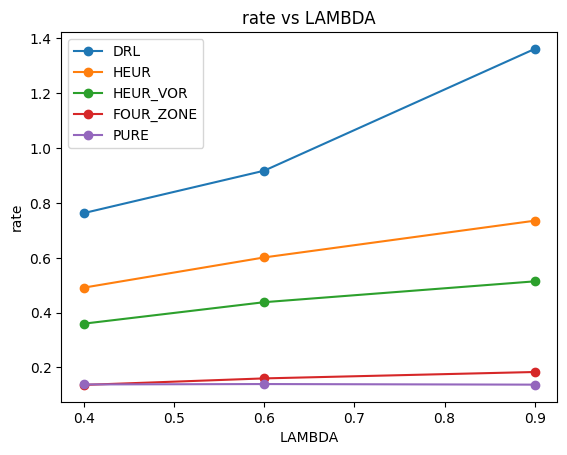

[PLOT] Saved plot_rate_vs_LAMBDA.png


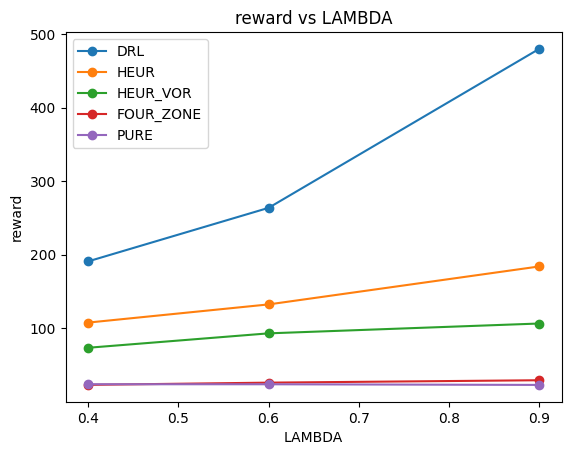

[PLOT] Saved plot_reward_vs_LAMBDA.png


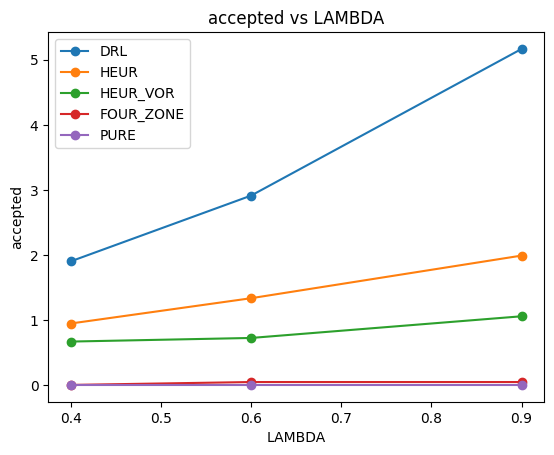

[PLOT] Saved plot_accepted_vs_LAMBDA.png


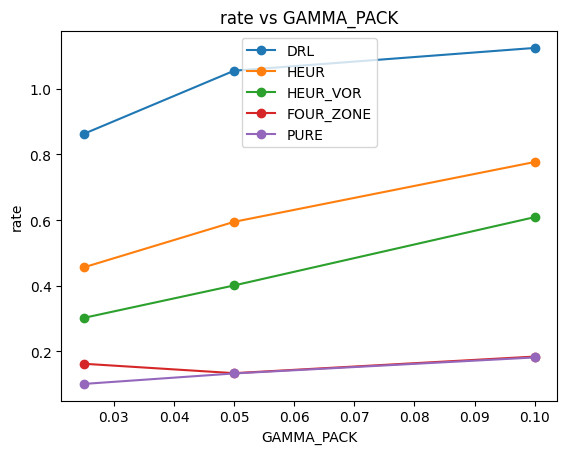

[PLOT] Saved plot_rate_vs_GAMMA_PACK.png


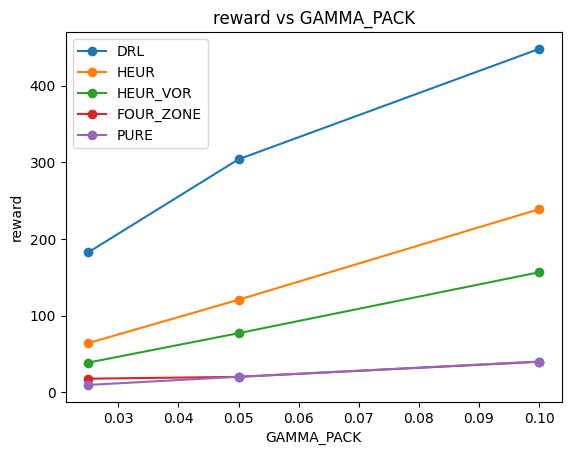

[PLOT] Saved plot_reward_vs_GAMMA_PACK.png


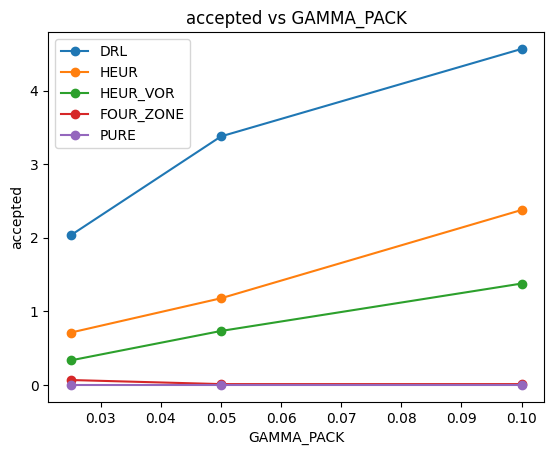

[PLOT] Saved plot_accepted_vs_GAMMA_PACK.png


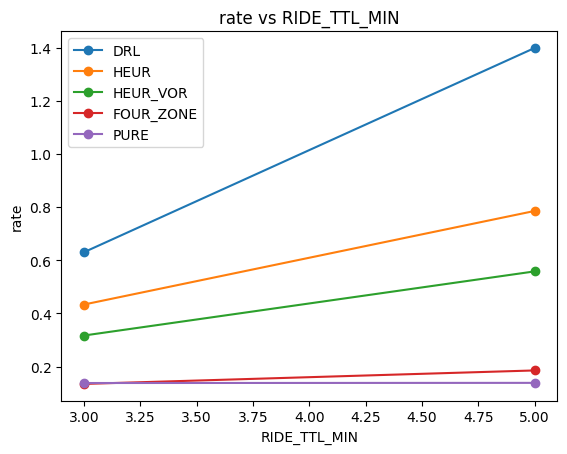

[PLOT] Saved plot_rate_vs_RIDE_TTL_MIN.png


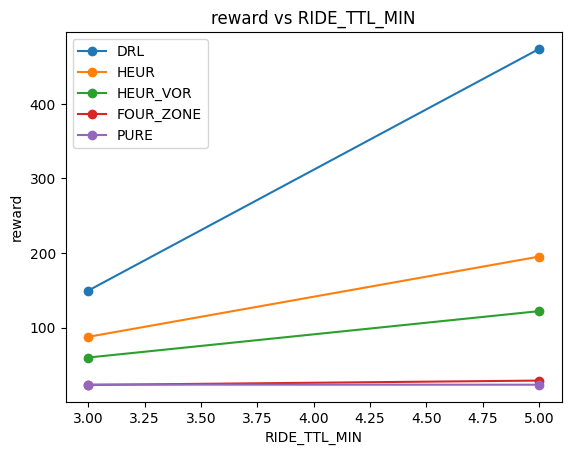

[PLOT] Saved plot_reward_vs_RIDE_TTL_MIN.png


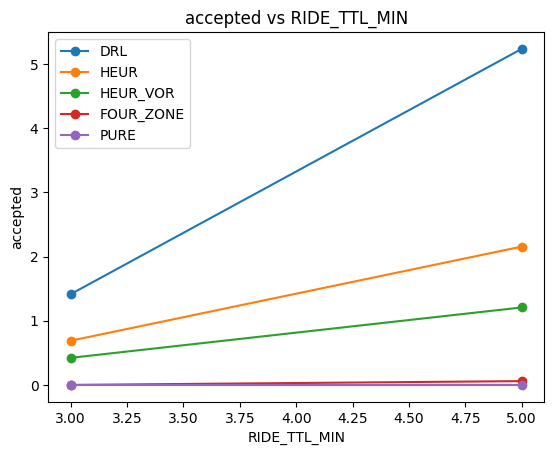

[PLOT] Saved plot_accepted_vs_RIDE_TTL_MIN.png


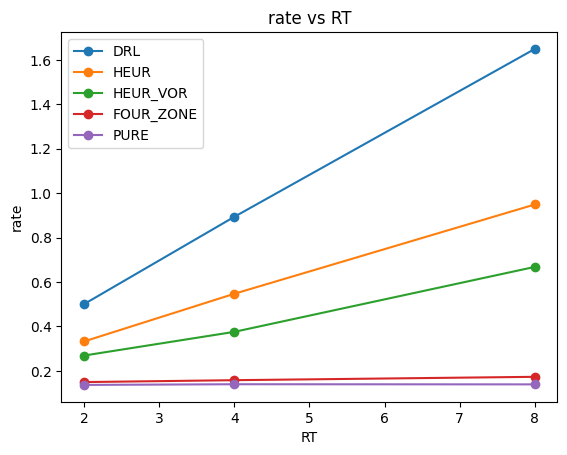

[PLOT] Saved plot_rate_vs_RT.png


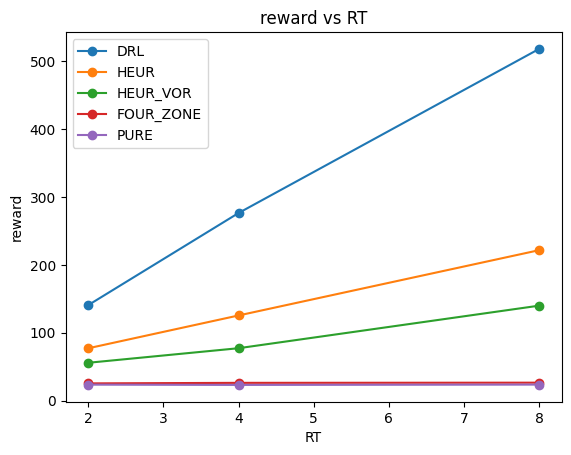

[PLOT] Saved plot_reward_vs_RT.png


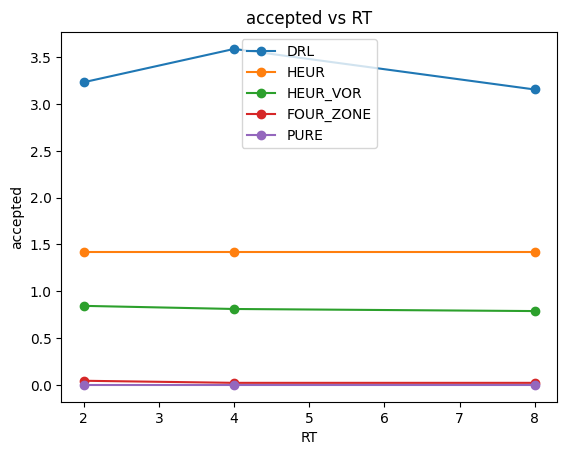

[PLOT] Saved plot_accepted_vs_RT.png


In [ ]:
LAMBDA_list            = [0.4, 0.6, 0.9]
R_PICK_ALPHA_list      = [0.6]
GAMMA_PACK_list        = [0.025, 0.05, 0.1]
RIDE_TTL_MINUTES_list  = [5]
MAX_VISIBLE_RIDES_list = [5]
SWITCH_GRACE_STEPS_list= [6]
RT_list                = [2.0,4.0,8.0]

CSV_PATH = "Results/param_sweep_results_2.csv"

df = run_param_sweep(LAMBDA_list,
                     R_PICK_ALPHA_list,
                     GAMMA_PACK_list,
                     RIDE_TTL_MINUTES_list,
                     MAX_VISIBLE_RIDES_list,
                     SWITCH_GRACE_STEPS_list,
                     RT_list,
                     train_updates_per_combo=20,      # Set to 20~50 for short DRL training. Set to 200 for full training of each parameter combination.
                     csv_path=CSV_PATH,
                     seed_offset=0)

display(df.head(12))
print(f"Saved to {CSV_PATH}")

# Plot single-parameter trend graphs (will be saved as PNG)
plot_from_csv(CSV_PATH,
              vary_keys=["LAMBDA","GAMMA_PACK",
                         "RIDE_TTL_MIN","RT"],
              metrics=("rate", "reward", "accepted"))


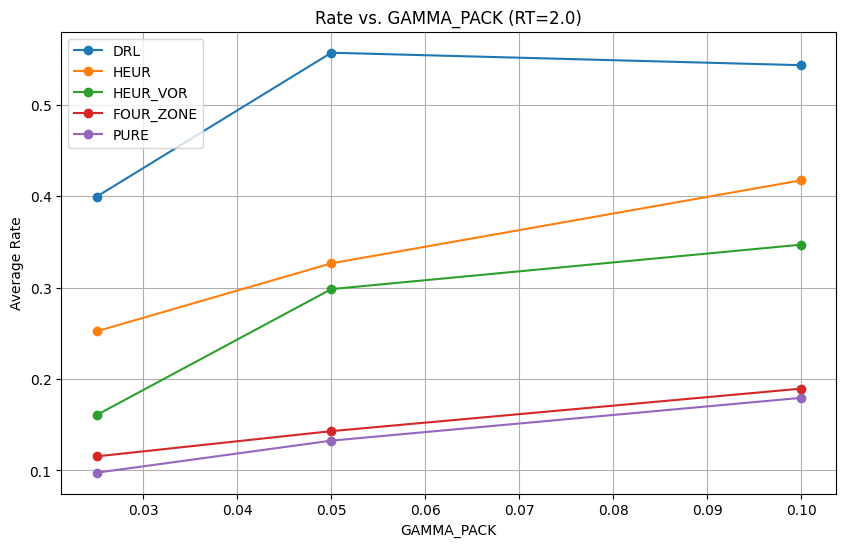

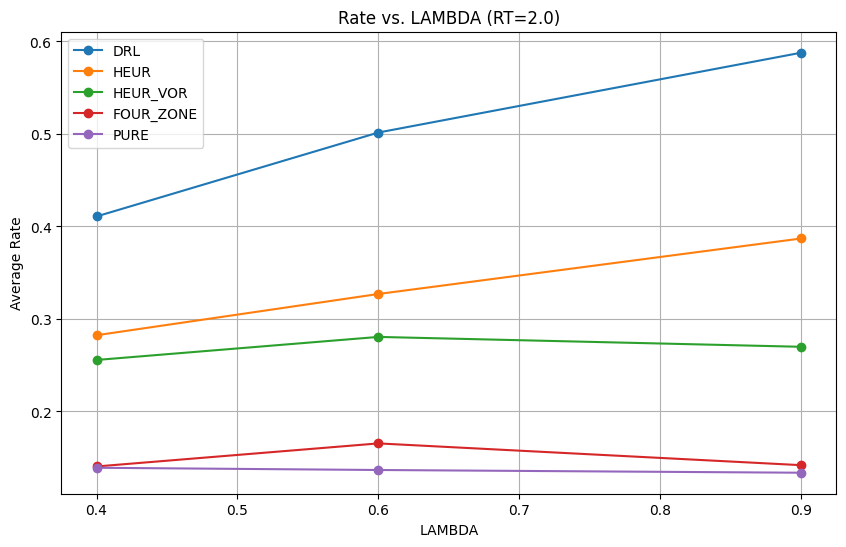

In [38]:
# Just to see the performance of the algorithms when RT = 2.0


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
csv_path = 'Results/param_sweep_results_2.csv'
df = pd.read_csv(csv_path)

# Filter for RT = 2.0
df_rt2 = df[df['RT'] == 2.0].copy()

# Define the algorithms to plot
algos = ["DRL", "HEUR", "HEUR_VOR", "FOUR_ZONE", "PURE"]

# --- Plot rate vs. GAMMA_PACK ---

# Group by algo and GAMMA_PACK, and calculate the mean rate
pivot_gamma = (df_rt2.groupby(["algo", "GAMMA_PACK"])["rate"]
                     .mean()
                     .reset_index()
                     .pivot(index="GAMMA_PACK", columns="algo", values="rate")
                     .sort_index())

# Plotting
plt.figure(figsize=(10, 6))
for algo in algos:
    if algo in pivot_gamma.columns:
        plt.plot(pivot_gamma.index.values, pivot_gamma[algo].values, marker="o", label=algo)

plt.xlabel("GAMMA_PACK")
plt.ylabel("Average Rate")
plt.title("Rate vs. GAMMA_PACK (RT=2.0)")
plt.legend()
plt.grid(True)
plt.show()


# --- Plot rate vs. LAMBDA ---

# Group by algo and LAMBDA, and calculate the mean rate
pivot_lambda = (df_rt2.groupby(["algo", "LAMBDA"])["rate"]
                      .mean()
                      .reset_index()
                      .pivot(index="LAMBDA", columns="algo", values="rate")
                      .sort_index())

# Plotting
plt.figure(figsize=(10, 6))
for algo in algos:
    if algo in pivot_lambda.columns:
        plt.plot(pivot_lambda.index.values, pivot_lambda[algo].values, marker="o", label=algo)

plt.xlabel("LAMBDA")
plt.ylabel("Average Rate")
plt.title("Rate vs. LAMBDA (RT=2.0)")
plt.legend()
plt.grid(True)
plt.show()



In [39]:
# The comparison of the average terminal time between HEUR and HEUR_VOR

# Load the dataset
csv_path = 'Results/param_sweep_results_2.csv'
df = pd.read_csv(csv_path)

# Filter for HEUR and HEUR_VOR algorithms
heur_df = df[df['algo'].isin(['HEUR', 'HEUR_VOR'])]

# Calculate and print the mean terminal_time for each
mean_terminal_time = heur_df.groupby('algo')['terminal_time'].mean()

print("Average Terminal Time Comparison:")
print(mean_terminal_time)



Average Terminal Time Comparison:
algo
HEUR        191.444444
HEUR_VOR    176.370370
Name: terminal_time, dtype: float64


In [40]:
# ==============
# Multi-subplot visualization: rate vs GAMMA_PACK for each fixed parameter combination
# ==============
def plot_rate_vs_gamma_by_params(csv_path: str, 
                                  algos=("DRL", "HEUR", "HEUR_VOR", "FOUR_ZONE", "PURE"),
                                  figsize_per_subplot=(6, 5),
                                  max_subplots_per_row=3,
                                  savepath: Optional[str] = None):
    """
    Create multiple subplots, each showing rate vs GAMMA_PACK for a fixed parameter combination.
    Each subplot only contains data for that specific parameter combination (no cross-combination averaging).
    
    Args:
        csv_path: Path to the CSV file containing parameter sweep results
        algos: Tuple of algorithm names to plot
        figsize_per_subplot: Tuple of (width, height) for each subplot
        max_subplots_per_row: Maximum number of subplots per row
        savepath: Optional path to save the figure
    """
    df = pd.read_csv(csv_path)
    
    # Identify parameter columns (excluding algo, GAMMA_PACK, and metric columns)
    param_cols = ["LAMBDA", "R_PICK_ALPHA", "RIDE_TTL_MIN", "MAX_VISIBLE_RIDES", "SWITCH_GRACE_STEPS", "RT"]
    # Filter to only include columns that exist in the dataframe
    param_cols = [col for col in param_cols if col in df.columns]
    
    # Get unique parameter combinations (excluding GAMMA_PACK)
    param_combos = df[param_cols].drop_duplicates().reset_index(drop=True)
    n_combos = len(param_combos)
    
    if n_combos == 0:
        print("No parameter combinations found. Please check your CSV file.")
        return
    
    # Calculate subplot grid dimensions
    n_rows = (n_combos + max_subplots_per_row - 1) // max_subplots_per_row
    n_cols = min(n_combos, max_subplots_per_row)
    
    # Create figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, 
                            figsize=(figsize_per_subplot[0] * n_cols, 
                                    figsize_per_subplot[1] * n_rows))
    
    # Flatten axes array for easier indexing
    if n_combos == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    # Plot each parameter combination
    for idx, (_, combo_row) in enumerate(param_combos.iterrows()):
        ax = axes[idx]
        
        # Filter data for this parameter combination
        mask = True
        for col in param_cols:
            mask = mask & (df[col] == combo_row[col])
        combo_df = df[mask].copy()
        
        # Group by algo and GAMMA_PACK, calculate mean rate
        pivot_data = (combo_df.groupby(["algo", "GAMMA_PACK"])["rate"]
                     .mean()
                     .reset_index()
                     .pivot(index="GAMMA_PACK", columns="algo", values="rate")
                     .sort_index())
        
        # Plot lines for each algorithm
        for algo in algos:
            if algo in pivot_data.columns:
                ax.plot(pivot_data.index.values, pivot_data[algo].values, 
                       marker="o", label=algo, linewidth=2, markersize=6)
        
        # Create multi-line title with parameter values for better readability
        title_parts = []
        for col in param_cols:
            if col in combo_row:
                # Format value based on type (integer vs float)
                val = combo_row[col]
                if isinstance(val, (int, np.integer)) or (isinstance(val, float) and val.is_integer()):
                    title_parts.append(f"{col}={int(val)}")
                else:
                    title_parts.append(f"{col}={val:.2f}")
        
        # Split title into two lines if too many parameters
        if len(title_parts) <= 3:
            title = "\n".join([", ".join(title_parts)])
        else:
            mid = len(title_parts) // 2
            title = "\n".join([", ".join(title_parts[:mid]), ", ".join(title_parts[mid:])])
        
        ax.set_title(title, fontsize=8, pad=10)
        ax.set_xlabel("GAMMA_PACK", fontsize=9)
        ax.set_ylabel("Rate", fontsize=9)
        ax.legend(fontsize=7, loc='best')
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(n_combos, len(axes)):
        axes[idx].axis('off')
    
    # Adjust layout with more spacing for titles
    plt.tight_layout(pad=2.0, h_pad=1.5, w_pad=1.0)
    
    if savepath:
        plt.savefig(savepath, bbox_inches="tight", dpi=150)
        print(f"[PLOT] Saved {savepath}")
    
    plt.show()



[PLOT] Saved plot_rate_vs_gamma_by_params.png


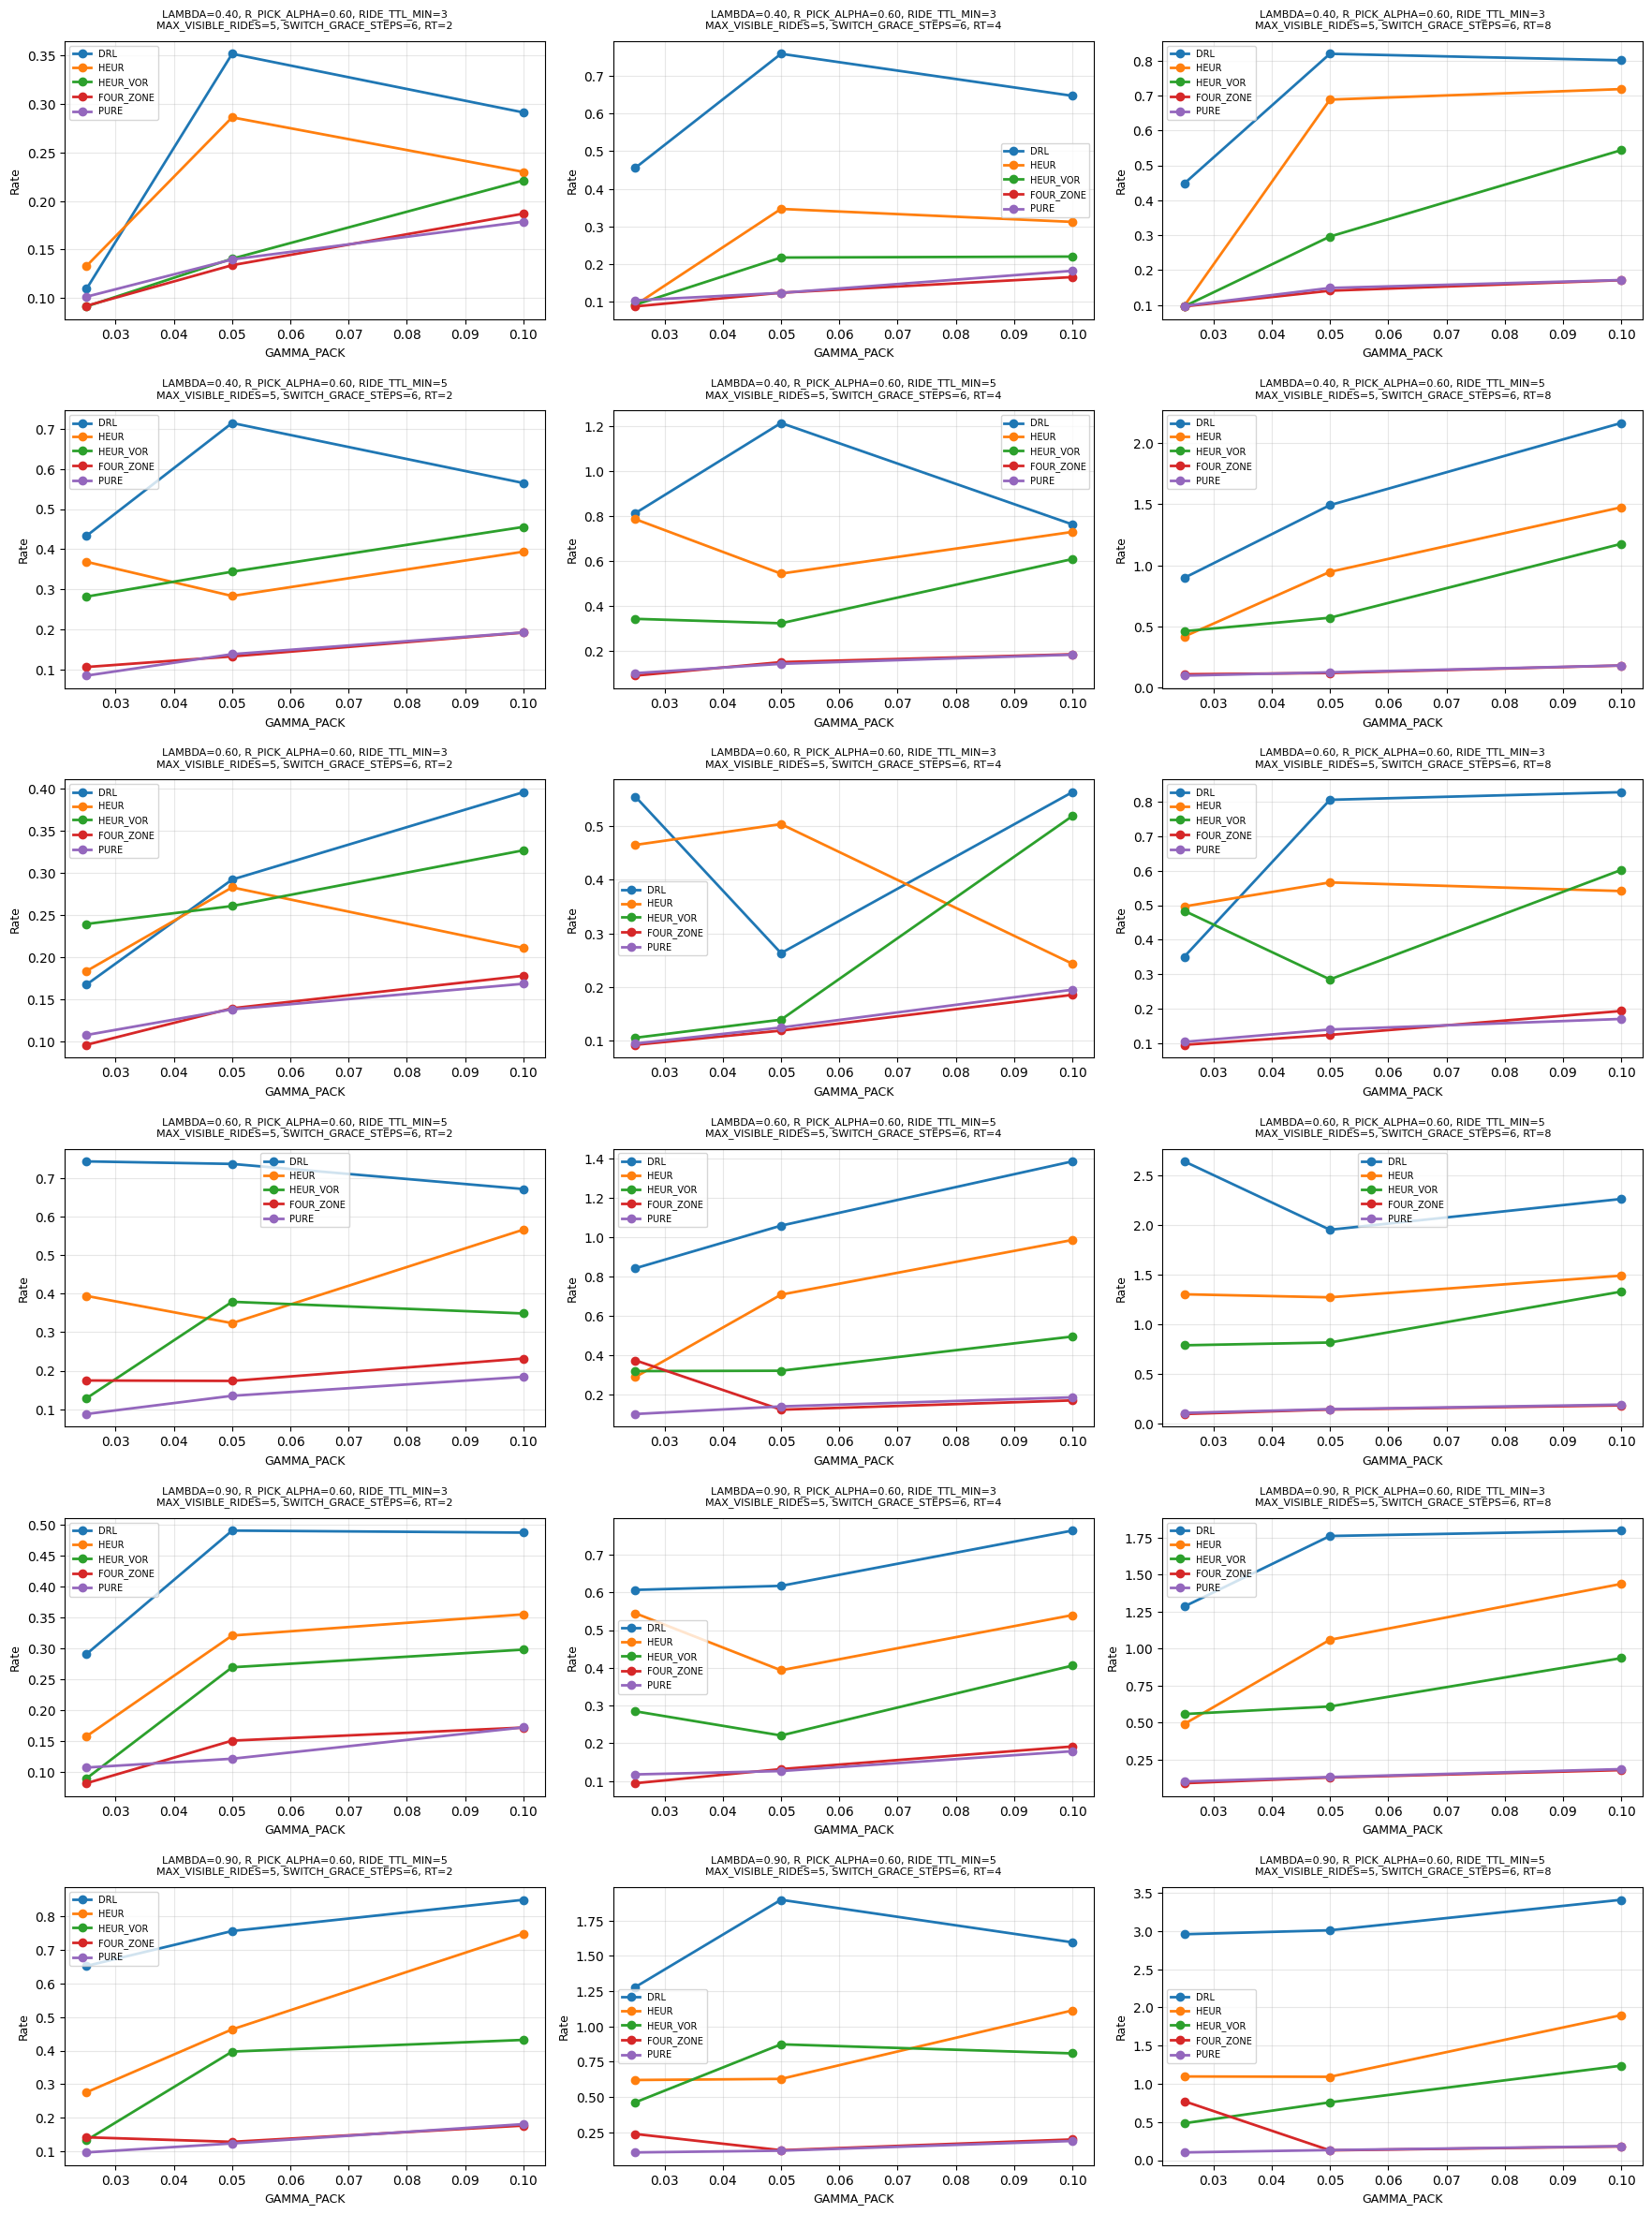

In [41]:
# Example usage: Plot rate vs GAMMA_PACK for each parameter combination
# This will create multiple subplots, one for each unique combination of 
# LAMBDA, R_PICK_ALPHA, RIDE_TTL_MIN, MAX_VISIBLE_RIDES, SWITCH_GRACE_STEPS, RT

plot_rate_vs_gamma_by_params(
    csv_path="Results/param_sweep_results_2.csv",
    algos=("DRL", "HEUR", "HEUR_VOR", "FOUR_ZONE", "PURE"),
    figsize_per_subplot=(6, 4),
    max_subplots_per_row=3,
    savepath="plot_rate_vs_gamma_by_params.png"  # Optional: save the figure
)

